<a href="https://colab.research.google.com/github/dlrow-olleh/Complexity-Project-2/blob/main/Final_S(ick)ugarscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

Downloaded utils.py
Downloaded Cell2D.py


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import random
import math
from utils import three_frame
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Created wheel for empiricaldist: filename=empiricaldist-0.6.2-py3-none-any.whl size=10737 sha256=95c57f6d6d82b6b1c17db571ce5a75b0aa88a93411747d260ba712f7aaa05241
  Stored in directory: /root/.cache/pip/wheels/34/22/5f/9ba9db604d08670e283b2e04551dd407f44cf889fdb9617ce5
Successfully built empiricaldist


In [3]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

In [4]:
make_locs(2, 3)

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2]])

In [5]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.
        
    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

In [6]:
make_visible_locs(2)

array([[-1,  0],
       [ 1,  0],
       [ 0,  1],
       [ 0, -1],
       [ 0, -2],
       [ 2,  0],
       [-2,  0],
       [ 0,  2]])

In [7]:
def distances_from(n, i, j):
    """Computes an array of distances.
    
    n: size of the array
    i, j: coordinates to find distance from
    
    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

In [8]:
dist = distances_from(5, 2, 2)
dist

array([[2.82842712, 2.23606798, 2.        , 2.23606798, 2.82842712],
       [2.23606798, 1.41421356, 1.        , 1.41421356, 2.23606798],
       [2.        , 1.        , 0.        , 1.        , 2.        ],
       [2.23606798, 1.41421356, 1.        , 1.41421356, 2.23606798],
       [2.82842712, 2.23606798, 2.        , 2.23606798, 2.82842712]])

In [9]:
bins = [3, 2, 1, 0]
np.digitize(dist, bins)

array([[1, 1, 1, 1, 1],
       [1, 2, 2, 2, 1],
       [1, 2, 3, 2, 1],
       [1, 2, 2, 2, 1],
       [1, 1, 1, 1, 1]])

In [10]:
def flip_transmit(p = 0.85):
  return np.random.random() < p

def flip_cured(p = 0.2):
  return np.random.random() < p

def flip_die(p = 0.4):
  return np.random.random() < p

def flip_immune(p = 0.05):
  return np.random.random() < p

In [11]:
def forsee_neighbors(env, loc, radius):
  neighbors = []
  for agent in env.agents:
          # if agent is self:
          #   continue
    offset = round(math.sqrt(((agent.loc[0]-loc[0])**2)+((agent.loc[1]-loc[1])**2))) #agent.loc - self.loc 
          #print(offset)
    if offset > radius:
      continue
    # neighbors.append(agent)
    if agent.is_sick():
      neighbors.append(agent)
        #print(neighbors)
  return neighbors

In [12]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, num_sick = 5, transmission_rate = 0.7, cure_rate = 0.5, random_sick_death_rate = 0.001, decision_weight = 0.5, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        self.transmission_rate = transmission_rate
        self.cure_rate = cure_rate
        self.random_sick_death_rate = random_sick_death_rate
        self.num_sick = num_sick
        self.decision_weight = decision_weight

        # track variables
        self.agent_count_seq = []
        self.agent_sick_count_seq = []
        self.death_ages = []
        self.deaths = []
        self.death_by_starving = []
        self.death_by_age = []
        self.death_by_sick = []
        self.death_by_random_sick = []
    
        # make the capacity array
        self.capacity = self.make_capacity()
        
        # initially all cells are at capacity
        self.array = self.capacity.copy()
        
        # make the agents
        self.make_agents()
        
    def make_capacity(self):
        """Makes the capacity array."""
        
        # compute the distance of each cell from the peaks. 
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)
        
        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a
        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params) 
                       for i in range(num_agents)]

        sick_ones = random.sample(self.agents, self.num_sick)
        #print(sick_one)
        for sick_one in sick_ones:
          sick_one.status = 1

        #print(sick_one.is_sick)
                
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)

    # def get_infected_neighbors(self, agents, radius):
    #   neighbors = []
    #   for agent in self.agents:
    #     if agent is self:
    #       continue
    #     offset =  agent.loc - self.loc
    #     if offset.mag>radius:
    #       continue
    #     if agent.is_sick():
    #       neighbors.append(agent)
    #   return neighbors
            
    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)

    
        
    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.
        
        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance
        
        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]

        #AVOIDANCE
        s_n = [len(forsee_neighbors(env, loc, 20)) for loc in empty_locs]
           
        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax([(1-self.decision_weight)*a - (self.decision_weight)*b for a, b in zip(t,s_n)])
        return empty_locs[i]
    
    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.
        
        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        deaths = 0
        starving = 0
        aging = 0
        sick = 0
        randomsick = 0
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            # execute one step
            agent.step(self)
            # print(agent.is_sick())

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old() or agent.sick_too_long() or (agent.is_sick() and flip_die(self.random_sick_death_rate)):
                deaths += 1
                if agent.is_starving():
                  starving += 1
                if agent.is_old(): 
                  aging +=1
                if agent.sick_too_long():
                  sick+= 1
                if (agent.is_sick() and flip_die(self.random_sick_death_rate)):
                  randomsick+=1
                self.agents.remove(agent)
                self.death_ages.append(agent.age)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)
            # if agent.get_infected_neighbors(self.agents, 60):
            #   agent.status == 1
            #print(agent.is_sick())
            

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        i = []
        for agent in self.agents:
          if agent.is_sick():
            i.append(agent)
        self.agent_sick_count_seq.append(len(i))
       
        # for agent in dead_agents:
        #   if agent.is_starving():
        #     starving += 1
        #   if agent.is_old():
        #     aging +=1
        #   if agent.sick_too_long():
        #     sick+= 1
        #   if agent.is_sick() and flip_die(self.random_sick_death_rate):
        #     randomsick+=1

        self.death_by_starving.append(starving)
        self.death_by_age.append(aging)
        self.death_by_sick.append(sick)
        self.death_by_random_sick.append(randomsick)
        self.deaths.append(deaths)
        
        # grow back some sugar
        self.grow()
        return len(self.agents)
    
    def add_agent(self):
        """Generates a new random agent.
                
        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        """Choose a random unoccupied cell.
        
        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc


    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')
        
        # draw the agents
        #xs, ys = self.get_coords()
        
        for agent in self.agents:
          x,y = agent.loc
          if agent.is_sick():
            self.points = plt.plot(x, y, '.', color='red')[0]
            #print(agent.is_sick)
          else :
            self.points = plt.plot(x, y, '.', color='blue')[0]

    # def get_coords(self):
    #     """Gets the coordinates of the agents.
    #     Transforms from (row, col) to (x, y).
    #     returns: tuple of sequences, (xs, ys)
    #     """
    #     agents = self.agents
    #     rows, cols = np.transpose([agent.loc for agent in agents])
    #     xs = cols + 0.5
    #     ys = rows + 0.5
    #     return xs, ys

In [13]:
class Agent:
    
    def __init__(self, loc , status = 0, **params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0
        self.status = 0 #keeps track of health status of each 
        self.sick_age = 0
        self.immunity = 0

        #0 for not sick and 1 for sick

        # extract the parameters
        max_vision = params.get('max_vision', 6)
        max_metabolism = params.get('max_metabolism', 4)
        min_lifespan = params.get('min_lifespan', 6000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sick_time = params.get('min_sick_lifespan',2000)
        max_sick_time = params.get('max_sick_lifespan',3500)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)
        
        # choose attributes
        self.vision = np.random.randint(1, max_vision+1)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)
        self.sick_time = np.random.uniform(min_sick_time,max_sick_time)

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = env.look_and_move(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1
        if self.is_sick():
          self.sick_age += 1
        if self.get_infected_neighbors(env.agents, 15):
          if flip_transmit(env.transmission_rate) and not self.is_immune(): #chancee of transmission:
              self.status = 1
        if self.sick_age >= 5: #minimum timesteps to be sick:
          if flip_cured(env.cure_rate): #change of being cured:
            self.status = 0
            self.sick_age = 0   
            if flip_immune(0.01):
              self.immunity = 1


    def get_infected_neighbors(self, agents, radius):
      neighbors = []
      for agent in env.agents:
        if agent is self:
          continue
        offset = round(math.sqrt(((agent.loc[0]-self.loc[0])**2)+((agent.loc[1]-self.loc[1])**2))) #agent.loc - self.loc 
        #print(offset)
        if offset > radius:
          continue
        if agent.is_sick():
          neighbors.append(agent)
      #print(neighbors)
      return neighbors
      
      # def forsee_neighbors(self, loc, radius):
      #   neighbors = []
      #   for agent in env.agents:
      #     if agent is self:
      #       continue
      #     offset = round(math.sqrt(((agent.loc[0]-loc[0])**2)+((agent.loc[1]-self[1])**2))) #agent.loc - self.loc 
      #     #print(offset)
      #     if offset > radius:
      #       continue
      #     if agent.is_sick():
      #       neighbors.append(agent)
      #   #print(neighbors)
      #   return neighbors

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan
    def sick_too_long(self):
      """Checks if agent has been sick too long"""
      return self.sick_age > self.sick_time
    
    def is_sick(self):
      """Checks if self is sick"""
      return self.status == 1
    
    def is_immune(self):
      return self.immunity == 1

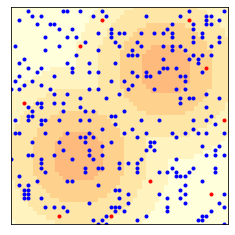

In [14]:
env = Sugarscape(50, num_agents=300, num_sick =10, transmission_rate= 0.65, cure_rate= 0.7,random_sick_death_rate=0.001,replace=False)
env.draw()

In [15]:
for i in range(15):
  env.step
#env.animate(frames=1000, interval=0.01)

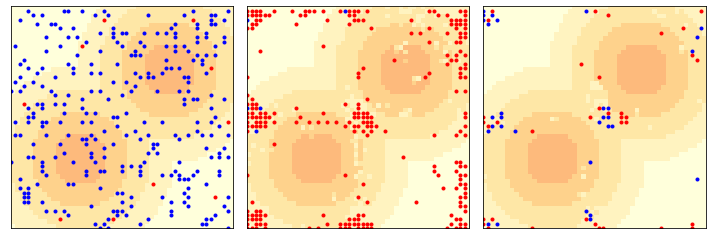

In [16]:
three_frame(env,[0,5,15])

In [17]:
#experiments to try:
  #weight desire for  want of food vs running from illness
  #how many stay alive in each scenario
  #what is the average lifespan in each scenario
  #average 'sugar level'
  #sick_ones each time step

Replacement = False



1. Food Weight 0,1  
Food weight 0.25,0.75
2.   Food weight 0.5,0.5,
3.   Food weight 0.75,0.25
Food Weight 1,0



In [18]:
fw01 = Sugarscape(50, num_agents=300, num_sick =10, transmission_rate= 0.65, cure_rate= 0.7,random_sick_death_rate=0.001, decision_weight = 1, replace=False)
fw13 = Sugarscape(50, num_agents=300, num_sick =10, transmission_rate= 0.65, cure_rate= 0.7,random_sick_death_rate=0.001, decision_weight = 0.75, replace=False)
fw11 = Sugarscape(50, num_agents=300, num_sick =10, transmission_rate= 0.65, cure_rate= 0.7,random_sick_death_rate=0.001, decision_weight = 0.5, replace=False)
fw31 = Sugarscape(50, num_agents=300, num_sick =10, transmission_rate= 0.65, cure_rate= 0.7,random_sick_death_rate=0.001, decision_weight = 0.25, replace=False)
fw10 = Sugarscape(50, num_agents=300, num_sick =10, transmission_rate= 0.65, cure_rate= 0.7,random_sick_death_rate=0.001, decision_weight = 0, replace=False)

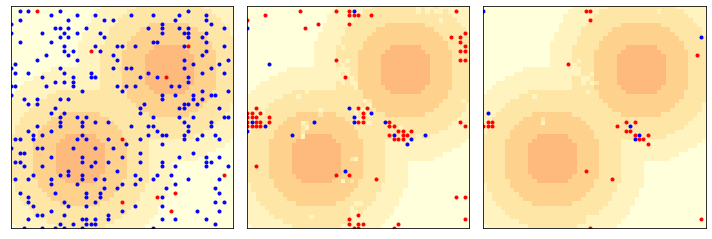

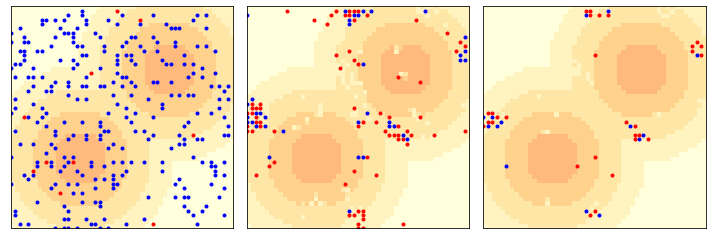

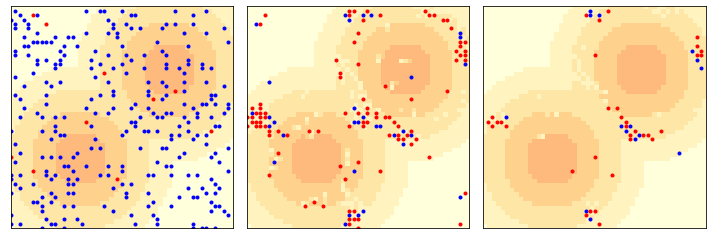

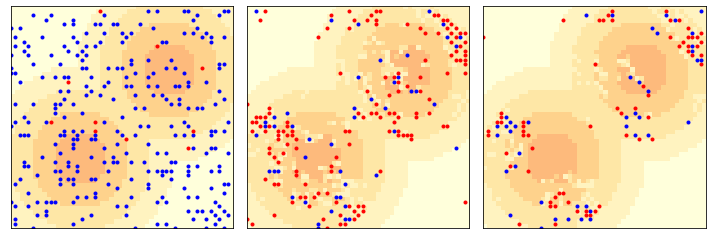

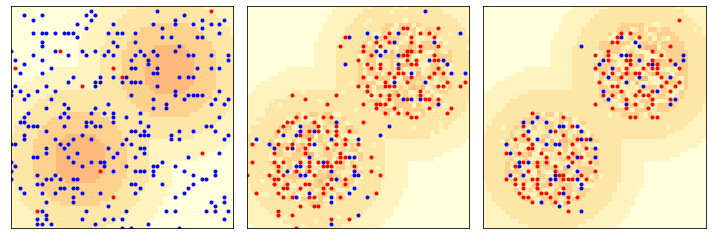

In [19]:
three_frame(fw01,[0,15,100])
three_frame(fw13,[0,15,100])
three_frame(fw11,[0,15,100])
three_frame(fw31,[0,15,100])
three_frame(fw10,[0,15,100])

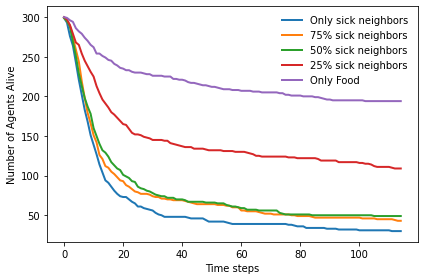

In [20]:
plt.plot(fw01.agent_count_seq, label='Only sick neighbors')
plt.plot(fw13.agent_count_seq, label = '75% sick neighbors')
plt.plot(fw11.agent_count_seq, label = '50% sick neighbors')
plt.plot(fw31.agent_count_seq, label = '25% sick neighbors')
plt.plot(fw10.agent_count_seq, label = 'Only Food')

decorate(xlabel='Time steps', ylabel='Number of Agents Alive')


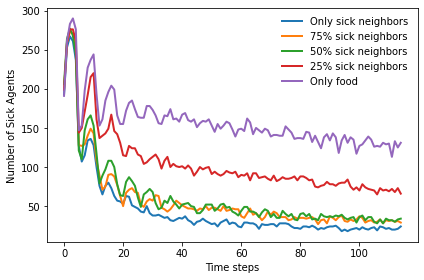

In [21]:

plt.plot(fw01.agent_sick_count_seq, label='Only sick neighbors')
plt.plot(fw13.agent_sick_count_seq, label = '75% sick neighbors')
plt.plot(fw11.agent_sick_count_seq, label = '50% sick neighbors')
plt.plot(fw31.agent_sick_count_seq, label = '25% sick neighbors')
plt.plot(fw10.agent_sick_count_seq, label = 'Only food')

decorate(xlabel='Time steps', ylabel='Number of Sick Agents')

In [22]:
print(len(fw01.agents))
print(len(fw13.agents))
print(len(fw11.agents))
print(len(fw31.agents))
print(len(fw10.agents))

30
43
49
109
194


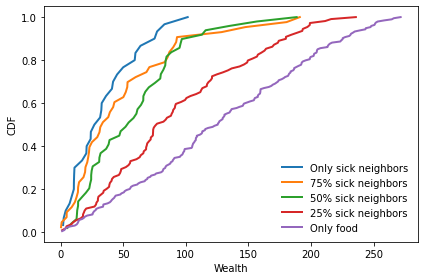

In [23]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(agent.sugar for agent in fw01.agents)
cdf2= Cdf.from_seq(agent.sugar for agent in fw13.agents)
cdf3 = Cdf.from_seq(agent.sugar for agent in fw11.agents)
cdf4 = Cdf.from_seq(agent.sugar for agent in fw31.agents)
cdf5 = Cdf.from_seq(agent.sugar for agent in fw10.agents)
cdf.plot(label='Only sick neighbors')
cdf2.plot(label = '75% sick neighbors')
cdf3.plot(label = '50% sick neighbors')
cdf4.plot(label = '25% sick neighbors')
cdf5.plot(label = 'Only food')
decorate(xlabel='Wealth', ylabel='CDF')

In [24]:
for agent in env.agents:
  env.death_ages.append(agent.age)
print(np.sum(env.death_ages)/len(env.death_ages))

11.96


Text(0.5, 0.98, 'Deaths with illness avoidance 100% prioritized')

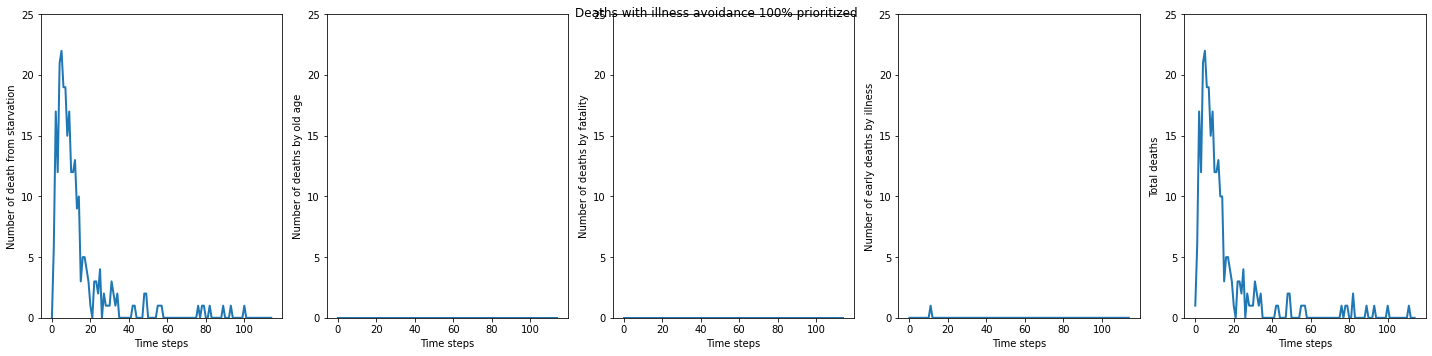

In [42]:
plt.figure(figsize=(20,5))
plt.subplot(1,5,1)
plt.plot(fw01.death_by_starving)
decorate(xlabel='Time steps', ylabel='Number of death from starvation',ylim = [0,25])
plt.subplot(1,5,2)
plt.plot(fw01.death_by_age)
decorate(xlabel='Time steps', ylabel='Number of deaths by old age',ylim = [0,25])
plt.subplot(1,5,3)
plt.plot(fw01.death_by_sick)
decorate(xlabel='Time steps', ylabel='Number of deaths by fatality',ylim = [0,25])
plt.subplot(1,5,4)
plt.plot(fw01.death_by_random_sick)
decorate(xlabel='Time steps', ylabel='Number of early deaths by illness',ylim = [0,25])
plt.subplot(1,5,5)
plt.plot(fw01.deaths)
decorate(xlabel='Time steps', ylabel='Total deaths',ylim = [0,25])
plt.suptitle('Deaths with illness avoidance 100% prioritized')


Text(0.5, 0.98, 'Deaths with illness avoidance 75% prioritized')

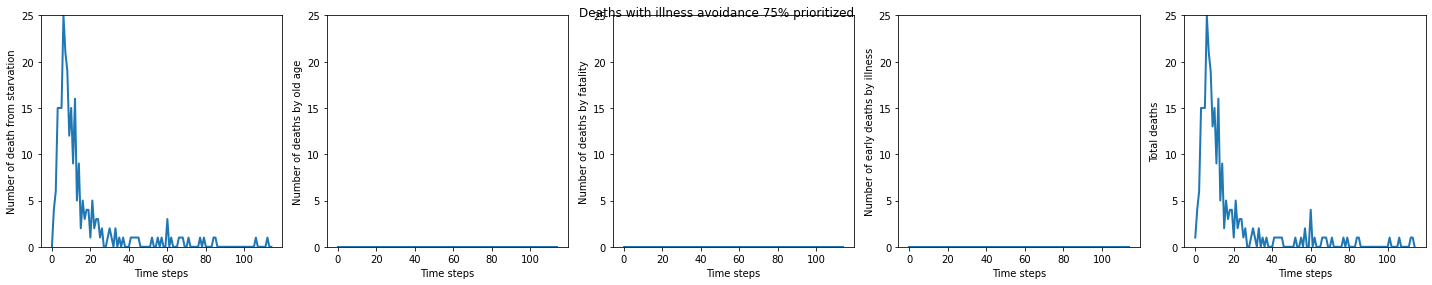

In [38]:
plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
plt.plot(fw13.death_by_starving)
decorate(xlabel='Time steps', ylabel='Number of death from starvation',ylim = [0,25])
plt.subplot(1,5,2)
plt.plot(fw13.death_by_age)
decorate(xlabel='Time steps', ylabel='Number of deaths by old age',ylim = [0,25])
plt.subplot(1,5,3)
plt.plot(fw13.death_by_sick)
decorate(xlabel='Time steps', ylabel='Number of deaths by fatality',ylim = [0,25])
plt.subplot(1,5,4)
plt.plot(fw13.death_by_random_sick)
decorate(xlabel='Time steps', ylabel='Number of early deaths by illness',ylim = [0,25])
plt.subplot(1,5,5)
plt.plot(fw13.deaths)
decorate(xlabel='Time steps', ylabel='Total deaths',ylim = [0,25])
plt.suptitle('Deaths with illness avoidance 75% prioritized')


Text(0.5, 0.98, 'Deaths with illness avoidance 50% prioritized')

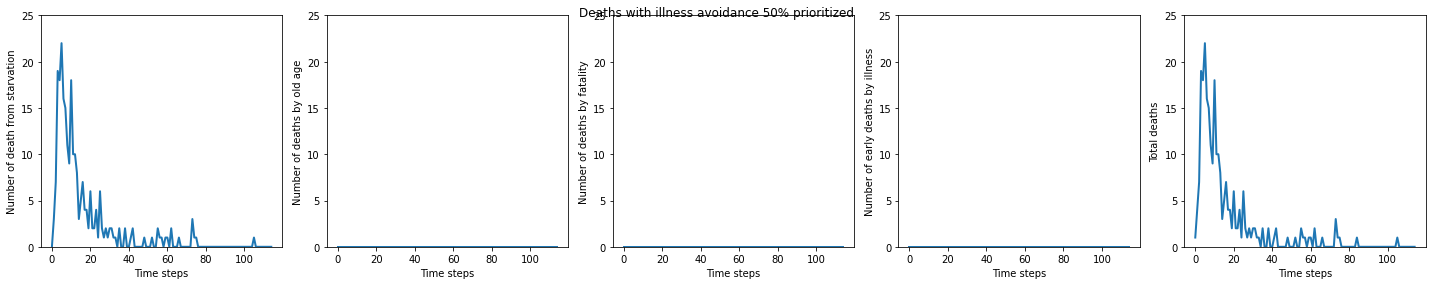

In [39]:
plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
plt.plot(fw11.death_by_starving)
decorate(xlabel='Time steps', ylabel='Number of death from starvation',ylim = [0,25])
plt.subplot(1,5,2)
plt.plot(fw11.death_by_age)
decorate(xlabel='Time steps', ylabel='Number of deaths by old age',ylim = [0,25])
plt.subplot(1,5,3)
plt.plot(fw11.death_by_sick)
decorate(xlabel='Time steps', ylabel='Number of deaths by fatality',ylim = [0,25])
plt.subplot(1,5,4)
plt.plot(fw11.death_by_random_sick)
decorate(xlabel='Time steps', ylabel='Number of early deaths by illness',ylim = [0,25])
plt.subplot(1,5,5)
plt.plot(fw11.deaths)
decorate(xlabel='Time steps', ylabel='Total deaths',ylim = [0,25])
plt.suptitle('Deaths with illness avoidance 50% prioritized')

Text(0.5, 0.98, 'Deaths with illness avoidance 25% prioritized')

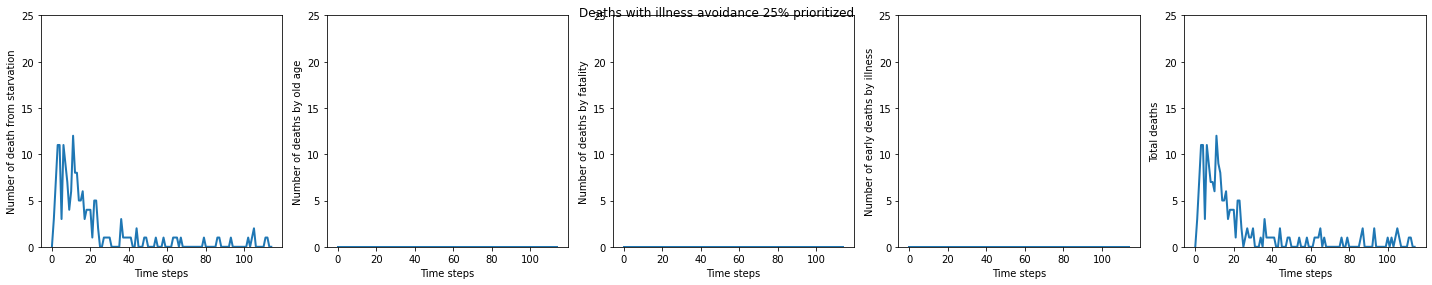

In [40]:
plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
plt.plot(fw31.death_by_starving)
decorate(xlabel='Time steps', ylabel='Number of death from starvation',ylim = [0,25])
plt.subplot(1,5,2)
plt.plot(fw31.death_by_age)
decorate(xlabel='Time steps', ylabel='Number of deaths by old age',ylim = [0,25])
plt.subplot(1,5,3)
plt.plot(fw31.death_by_sick)
decorate(xlabel='Time steps', ylabel='Number of deaths by fatality',ylim = [0,25])
plt.subplot(1,5,4)
plt.plot(fw31.death_by_random_sick)
decorate(xlabel='Time steps', ylabel='Number of early deaths by illness',ylim = [0,25])
plt.subplot(1,5,5)
plt.plot(fw31.deaths)
decorate(xlabel='Time steps', ylabel='Total deaths',ylim = [0,25])
plt.suptitle('Deaths with illness avoidance 25% prioritized')

Text(0.5, 0.98, 'Deaths with illness avoidance 0% prioritized')

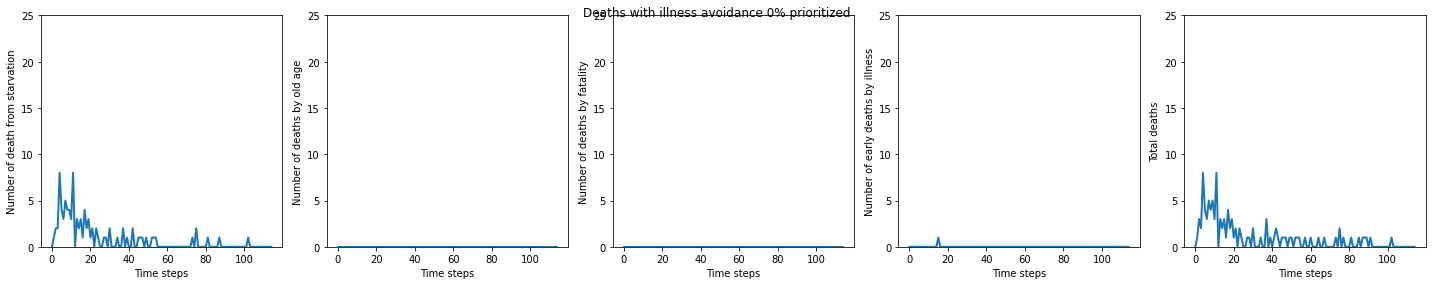

In [41]:
plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
plt.plot(fw10.death_by_starving)
decorate(xlabel='Time steps', ylabel='Number of death from starvation',ylim = [0,25])
plt.subplot(1,5,2)
plt.plot(fw10.death_by_age)
decorate(xlabel='Time steps', ylabel='Number of deaths by old age',ylim = [0,25])
plt.subplot(1,5,3)
plt.plot(fw10.death_by_sick)
decorate(xlabel='Time steps', ylabel='Number of deaths by fatality',ylim = [0,25])
plt.subplot(1,5,4)
plt.plot(fw10.death_by_random_sick)
decorate(xlabel='Time steps', ylabel='Number of early deaths by illness',ylim = [0,25])
plt.subplot(1,5,5)
plt.plot(fw10.deaths)
decorate(xlabel='Time steps', ylabel='Total deaths',ylim = [0,25])
plt.suptitle('Deaths with illness avoidance 0% prioritized')

Replacement = true